# Full Code Version 1
This script will contain the full code for the SU2 local mesh refinement.

**Installing the correct packages**

In [1]:
#conda install -c anaconda vtk

In [2]:
#pip install pyvistaqt

**Importing the required packages**

In [3]:
import numpy as np
import pyvista as pv
from pyvista import examples
import vtk
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pyvistaqt as pvqt
import math

**Loading in the SU2 data**

In [4]:
pd = pv.read('C:/Users/20192167/Documents/Boeken/BEP/SU2-master/SU2-master/QuickStart/flow.vtu')
pd

UnstructuredGrid (0x2b5fedff940)
  N Cells:	10216
  N Points:	5233
  X Bounds:	-2.000e+01, 2.000e+01
  Y Bounds:	-1.996e+01, 1.996e+01
  Z Bounds:	0.000e+00, 0.000e+00
  N Arrays:	7

In [5]:
density = pd['Density']
momentum = pd['Momentum']
energy = pd['Energy']
pressure = pd['Pressure']
temperature = pd['Temperature']
mach = pd['Mach']
pressure_coefficient = pd['Pressure_Coefficient']

**Sorting the data per cell** (Example Temperature)

In [6]:
cells=pd.cells
points=pd.points

Centers = []
cellsC = cells

while True:
    if cellsC[0]==3:
        a = cellsC[1]
        b = cellsC[2]
        c = cellsC[3]
        
        C = (temperature[a]+temperature[b]+temperature[c])/3
        Centers.append(C)
        cellsC = cellsC[4:]
        
    elif cellsC[0]==4:
        a = cellsC[1]
        b = cellsC[2]
        c = cellsC[3]
        d = cellsC[4]
        
        C = (temperature[a]+temperature[b]+temperature[c]+temperature[d])/4
        Centers.append(C)
        cellsC = cellsC[5:]
    
    if len(cellsC) == 0:
        break
        
Centers

[251.75836181640625,
 259.2937825520833,
 277.1942138671875,
 252.0662841796875,
 253.13798014322916,
 286.6274007161458,
 267.5084228515625,
 249.49454752604166,
 299.5664876302083,
 267.0081787109375,
 225.3115234375,
 280.5158284505208,
 226.3529256184896,
 259.0219319661458,
 305.0590006510417,
 286.1806233723958,
 305.0369059244792,
 249.23616536458334,
 279.1359049479167,
 270.05224609375,
 284.36083984375,
 273.3275960286458,
 229.97125244140625,
 267.7151285807292,
 243.40826416015625,
 279.3916422526042,
 290.71754964192706,
 271.5277099609375,
 225.4369913736979,
 273.2127278645833,
 274.4410400390625,
 269.5954182942708,
 251.7281290690104,
 276.5891927083333,
 274.6990966796875,
 271.7178955078125,
 291.69952392578125,
 275.55084228515625,
 261.4295247395833,
 277.3067220052083,
 286.9405924479167,
 266.29868570963544,
 292.1177164713542,
 287.52392578125,
 262.60101318359375,
 282.6846110026042,
 260.1676025390625,
 267.8058675130208,
 271.8535970052083,
 268.9582112630208

**Visualizing the distribution**

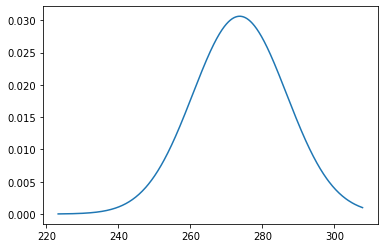

In [7]:
centersImage = Centers.copy()
centersImage.sort()

# Calculating mean and standard deviation
mean = np.mean(centersImage)
std = np.std(centersImage)
plt.plot(centersImage, norm.pdf(centersImage, mean, std))
plt.show()

**Visualizing the Data in Paraview**

In [8]:
# Define the colors we want to use
green = np.array([200/256, 247/256, 0/256, 1])
greenblue = np.array([12/256, 238/256, 200/256, 1])
blue = np.array([12/256, 238/256, 246/256, 1])
darkblue = np.array([12/256, 150/256, 246/256, 1])
purple= np.array([200/256, 50/256, 246/256, 1])
pink= np.array([250/256, 50/256, 246/256, 1])
lightpink = np.array([250/256, 50/256, 246/256, 0.7])
orange = np.array([250/256, 150/256, 0/256, 0.7])
yelloworange = np.array([250/256, 200/256, 0/256, 0.7])
yellow = np.array([255/256, 247/256, 0/256, 1])
grey = np.array([189/256, 189/256, 189/256, 1])

Temperature = np.linspace(pd['Temperature'].min(), pd['Temperature'].max(), 256)

newcolors = np.empty((256, 4))
newcolors[Temperature >= 200] = green
newcolors[Temperature > 210] = greenblue
newcolors[Temperature > 220] = blue
newcolors[Temperature > 230] = darkblue
newcolors[Temperature > 240] = purple
newcolors[Temperature > 250] = pink
newcolors[Temperature > 260] = lightpink
newcolors[Temperature > 270] = orange
newcolors[Temperature > 280] = yelloworange
newcolors[Temperature > 290] = yellow
newcolors[Temperature >= 300] = grey

my_colormap = ListedColormap(newcolors)

pl = pvqt.BackgroundPlotter()
pl.set_background('white')
pv.global_theme.font.color = 'black'
pl.add_mesh(pd, show_edges=True, line_width=0.5,scalars='Temperature',
            cmap=my_colormap,clim=[200, 300])
pl.camera_position = 'xy'
pl.show()

**Determining which cells should be refined**

In [9]:
Index = []
Option= 1 # 1=min or max value, 2 = min or max percentage

if Option == 1:
    for x in range(0, len(Centers)):
        if Centers[x] <= 250:
            Index.append(x)
            
elif Option == 2:
    margin = np.percentile(Centers, 90)

    for x in range(0, len(Centers)):
        if Centers[x] >= margin:
            Index.append(x)

**Loading in the SU2 mesh file**

In [10]:
f = open('C:\\Users\\20192167\\Documents\\Boeken\\BEP\\SU2-master\\SU2-master\\QuickStart\\mesh_NACA0012_inv_original.su2', 'r')


# first get the dimensions
line = f.readline()
columns = line.split()
print(columns)

NDIME = columns[1]
print("dimensions = ",NDIME)

# then, get the nr of elements
line = f.readline()
columns = line.split()

NELEM=columns[1]
print("nr of elements=",NELEM)

# create the 2D triangle array
connectivity = np.arange(4*int(NELEM),dtype=np.int32)
connectivity = connectivity.reshape(int(NELEM),4)
                    
# now, read all the elements into a structure
for i in range(int(NELEM)):
    line=f.readline()
    columns = line.split()
    connectivity[i][:]=[int(3), int(columns[1]), int(columns[2]), int(columns[3])]
    
print("end reading elements")
# then, get the coordinates
line = f.readline()
columns = line.split()

NPOIN=columns[1]
print("nr of points=",NPOIN)

# create the 2D point array
points = np.arange(2*int(NPOIN),dtype=np.float64).reshape(int(NPOIN),2)
# now, read all the points into a structure
for i in range(int(NPOIN)):
    line=f.readline()
    columns = line.split()
    points[i][0]=float(columns[0])
    points[i][1]=float(columns[1])

# now, read the markers
line = f.readline()
columns = line.split()

NMARK=columns[1]
print("nr of markers=",NMARK)

# name of the marker (list of strings)
markername = []
# number of elements in the marker (list of integers)
markerelements = np.arange(int(NMARK),dtype=np.int32)
# this is the list of numpy arrays
markers = []

# list of marker points
markerpointslist = []

for m in range(int(NMARK)):
    line = f.readline()
    columns = line.split()
    markername.append(columns[1])
    print(" ",m,": marker name=",markername[m])
    line = f.readline()
    columns = line.split()
    markerelements[m] = int(columns[1])   
    print(" marker elements=",markerelements[m])
    markerarray = np.arange(2*int(markerelements[m])).reshape(int(markerelements[m]),2)

    for i in range(int(markerelements[m])):
        line=f.readline()
        columns = line.split()
        markerarray[i][0]=columns[1]
        markerarray[i][1]=columns[2]
        
    # now add the array to the list of markers
    markers.append(markerarray)

print("Finished reading su2 file.") 

['NDIME=', '2']
dimensions =  2
nr of elements= 10216
end reading elements
nr of points= 5233
nr of markers= 2
  0 : marker name= airfoil
 marker elements= 200
  1 : marker name= farfield
 marker elements= 50
Finished reading su2 file.


In [11]:
cells = connectivity
cells

array([[   3,  417,   69,  311],
       [   3,  302,   55,   56],
       [   3,  405,  159,  384],
       ...,
       [   3, 5105, 5061, 5029],
       [   3, 5134, 5106, 5097],
       [   3, 5122, 5109, 5075]])

In [12]:
n = int(NPOIN)
z = np.zeros((n, 1))
p = np.append(points, z, axis=1)
points = p
points

array([[ 9.99750018e-01, -3.63289652e-05,  0.00000000e+00],
       [ 9.99000013e-01, -1.45253750e-04,  0.00000000e+00],
       [ 9.97759998e-01, -3.25111163e-04,  0.00000000e+00],
       ...,
       [ 1.75493202e+01,  3.08875299e+00,  0.00000000e+00],
       [ 1.14168196e+01,  1.40551205e+01,  0.00000000e+00],
       [ 1.71931591e+01,  7.91305924e+00,  0.00000000e+00]])

In [13]:
markers0 = markers

**Visualizing the mesh with Paraview**

In [14]:
mesh = pv.PolyData(points, connectivity)
pl = pvqt.BackgroundPlotter()
pl.add_mesh(mesh, show_edges=True, line_width=0.05, color='#EEEEEE')
pl.set_background('white')
#pl.add_point_labels(points, [f'Point {i}' for i in range(5)],always_visible=True,
#                    font_size=20,text_color='white', point_size=20,point_color='red',render_points_as_spheres=True)
pl.camera_position = 'xy'
pl.show()

**Refining the mesh**

In [15]:
c = Index[:5].copy()
c

[7, 10, 12, 17, 22]

In [16]:
#-------------------------------------------------------------------------------#    
#--------Finding the neighbouring cells of the cells you wish to refine---------#
#-------------------------------------------------------------------------------#

len_points = len(points) #the total number of points in the mesh
len_cells = len(cells) #the total number of cells in the mesh
  
clen = len(c) #the total number of cells you wish to refine
ytotal = []  #numbers of the neigbouring cells of all cells you wish to refine in array per cell
ytotaly = [] #numbers of the neigbouring cells of all cells you wish to refine

for cx in range(0,clen): #for every cell listed in array {c}
    
    d = cells[c[cx]][1] #the first point of the cell
    e = cells[c[cx]][2] #the second point of the cell
    f = cells[c[cx]][3] #the third point of the cell
    cy=[d,e,f] #the numbers of the points creating the cell

    y = [] #numbers of the neighbouring cells of cell cx
    v = 0 #temporary variable

    for x in range(0,len_cells): #for all cells in the mesh
        if d in cells[x][1:] and e in cells[x][1:]: #looks for the side DE in the other cells
            if x not in c:
                y.append(x) #if a second listing of DF is present the number of that cell is added to the list
                ytotaly.append(x)
                v=1
    if v!= 1:
        y.append(len_cells+1) #adds a cell that is not in the mesh to the array {y}
        ytotaly.append(len_cells+1)
        
    v=0
    for x in range(0,len_cells): #for all cells in the mesh
        if e in cells[x][1:] and f in cells[x][1:]: #looks for the side EF in the other cells
            if x not in c:
                y.append(x) #if a second listing of DF is present the number of that cell is added to the list
                ytotaly.append(x)
                v=1
    if v!= 1:
        y.append(len_cells+1) #adds a cell that is not in the mesh to the array {y}
        ytotaly.append(len_cells+1)
        
    v=0
    for x in range(0,len_cells): #for all cells in the mesh
        if d in cells[x][1:] and f in cells[x][1:]: #looks for the side DF in the other cells
            if x not in c:
                y.append(x) #if a second listing of DF is present the number of that cell is added to the list
                ytotaly.append(x)
                v=1   
    if v!= 1:
        y.append(len_cells+1) #adds a cell that is not in the mesh to the array {y}
        ytotaly.append(len_cells+1)
        
    ytotal.append(y)
    
#-------------------------------------------------------------------------#
#---------Finding neighbouring cells that are called for twice------------#
#-------------------------------------------------------------------------#
i=0
for x in range (0,len(ytotal)): #for every cell listed in {ytotal}
    for z in range(0,3): 
        
        if ytotal[x][z] in ytotaly[3+i:]: #if the cell is listed again in {ytotal}
            if ytotal[x][z] != len_cells+1: #if it is not the additional cell added for no connection
                if ytotal[x] not in c: #if the cell is not listed in {c}
                    c.append(ytotal[x][z]) #add the cell to {c}
                    v =1
            else:
                v=0
        else:
            v =0

    i = i+3
if len(c)==clen: #if at least two cells share the same neighbouring cell. The code will be ran again.
    a=1
    
else:
    while True:
        clen=len(c) #the new total number of cells you wish to refine
        ytotal = [] #numbers of the neigbouring cells of all cells you wish to refine
        ytotaly= []
        #-------------------------------------------------------------------------------#    
        #--------Finding the neighbouring cells of the cells you wish to refine---------#
        #-------------------------------------------------------------------------------#

        for cx in range(0,clen): #for every cell listed in array {c}
    
            d = cells[c[cx]][1] #the first point of the cell
            e = cells[c[cx]][2] #the second point of the cell
            f = cells[c[cx]][3] #the third point of the cell
            cy=[d,e,f] #the numbers of the points creating the cell

            y = [] #numbers of the neighbouring cells of cell cx
            v = 0 #temporary variable

            for x in range(0,len_cells): #for all cells in the mesh
                if d in cells[x][1:] and e in cells[x][1:]: #looks for the side DE in the other cells
                    if x not in c:
                        y.append(x) #if a second listing of DF is present the number of that cell is added to the list
                        ytotaly.append(x)
                        v=1
            if v!= 1:
                y.append(len_cells+1) #adds a cell that is not in the mesh to the array {y}
                ytotaly.append(len_cells+1)

            v=0
            for x in range(0,len_cells): #for all cells in the mesh
                if e in cells[x][1:] and f in cells[x][1:]: #looks for the side EF in the other cells
                    if x not in c:
                        y.append(x) #if a second listing of DF is present the number of that cell is added to the list
                        ytotaly.append(x)
                        v=1
            if v!= 1:
                y.append(len_cells+1) #adds a cell that is not in the mesh to the array {y}
                ytotaly.append(len_cells+1)

            v=0
            for x in range(0,len_cells): #for all cells in the mesh
                if d in cells[x][1:] and f in cells[x][1:]: #looks for the side DF in the other cells
                    if x not in c:
                        y.append(x) #if a second listing of DF is present the number of that cell is added to the list
                        ytotaly.append(x)
                        v=1   
            if v!= 1:
                y.append(len_cells+1) #adds a cell that is not in the mesh to the array {y}
                ytotaly.append(len_cells+1)

            ytotal.append(y)

        #-------------------------------------------------------------------------#
        #---------Finding neighbouring cells that are called for twice------------#
        #-------------------------------------------------------------------------#

        i=0
        for x in range (0,len(ytotal)): #for every cell listed in {ytotal}
            for z in range(0,3): 

                if ytotal[x][z] in ytotaly[3+i:]: #if the cell is listed again in {ytotal}
                    if ytotal[x][z] != len_cells+1: #if it is not the additional cell added for no connection
                        if ytotal[x] not in c: #if the cell is not listed in {c}
                            c.append(ytotal[x][z]) #add the cell to {c}
                            v =1
                    else:
                        v=0
                else:
                    v =0

            i = i+3

        if len(c)==clen: #if at least two cells share the same neighbouring cell. The code will be ran again.
            break

            
#------------------------------------------------------------------#
#--------Taking out the cells that are already to be refined-------#
#------------------------------------------------------------------#

yleft = ytotal #the numbers of the cells that need to be split in two

for x in range (0,len(ytotal)): #for all neigbouring cells
    for z in range(0,3): 
        if ytotal[x][z] in c: #if a cell listed in {ytotal} is already in {c}
            yleft[x][z] = len_cells+1 #all cells that are already being refined are replaced by the number len_cells+1
        elif ytotal:
            v=0
            
#---------------------------------------------------------------#
#--------Determining which point the cells do not share---------#
#---------------------------------------------------------------#

r=[] #an array containing a 1 for sharing and a 0 for not sharing
for cx in range(0,clen):
    rx = [] #temporary storange array
    y = yleft[cx] #the numbers of the neigbouring cells
        
    d = cells[c[cx]][1] #first point of the cell
    e = cells[c[cx]][2] #second point of the cell
    f = cells[c[cx]][3] #third point of the cell
    cy=[d,e,f] #the numbers of the points creating the cell
    
    for x in range (0,3):
        if y[x] <= len_cells:
            q = cells[y[x]][1:] #points in the neighbouring cell
            for x in range (0,3):
                q1 = q[x]
                if q1 in cy: #if two cells share a point
                    t = 1
                    rx.append(t)
                else: # if two cells do not share a point
                    t = 0
                    rx.append(t)
        else:
            rx.append(0)
            rx.append(0)
            rx.append(0)
    r.append(rx)

#---------------------------------------#
#-----Splitting the cell in four--------# 
#---------------------------------------#
for cx in range(0,clen):
     
    d = cells[c[cx]][1]
    e = cells[c[cx]][2]
    f = cells[c[cx]][3]
    
    point1 = ((points[e]+points[d])/2) #creating a additional point in the middle of the first edge of the side
    point2 = ((points[f]+points[e])/2) #creating a additional point in the middle of the second edge of the side
    point3 = ((points[d]+points[f])/2) #creating a additional point in the middle of the third edge of the side
    points = np.vstack([points,point1,point2,point3]) #adding the points to the points array
    
    g = len(points) #the new total number of points
    
    #changing the original cell to to the refined cell
    cells[c[cx]]= [3, (g-1),(g-2),f] 
    cells = np.vstack([cells, [3, d,(g-1),(g-3)]])
    cells = np.vstack([cells, [3, (g-2),e,(g-3)]])
    cells = np.vstack([cells, [3, (g-1),(g-2),(g-3)]])
    
    #------------------------------------#
    #------Adjusting marker lines--------#
    #------------------------------------#
    
    for x in range(0,len(markers0)): #for all cells in the mesh

        if d in markers0[x] and e in markers0[x]: #looks for the side DE in the other cells
            mmarker = []
            mcell = []
            mmarker.append(x) #if a second listing of DF is present the number of that cell is added to the list
            mcell.append(c[cx])
            
            u = 0
            while True:
                print(d,e, markers0[x][u])
                if d in markers0[x][u] and e in markers0[x][u]:
                    break 
                u=u+1
            
            if c[cx] in mcell:
                v = markers0[mmarker[0]][u]
                markerx = [markers0[mmarker[x]][u][0], (g-3)]
                markers0[mmarker[0]][u] = [(g-3) ,markers0[mmarker[x]][u][1]]
                markers0[x] = np.vstack([markers0[x][:u], markerx, markers0[x][u:]])
            
            markerelements[x]=len(markers0[x])
        
    for x in range(0,len(markers0)): #for all cells in the mesh
        if e in markers0[x] and f in markers[x]: #looks for the side DE in the other cells
            mmarker = []
            mcell = []
            mmarker.append(x) #if a second listing of DF is present the number of that cell is added to the list
            mcell.append(c[cx])
                
            u = 0
            while True:
                if e in markers0[x][u] and f in markers0[x][u]:
                    break 
                u=u+1
            
            if c[cx] in mcell:
                markerx = [markers0[mmarker[x]][u][0], (g-2)]
                markers0[mmarker[0]][u] = [(g-2), markers0[mmarker[x]][u][1]]
                markers0[x] = np.vstack([markers0[x][:u], markerx, markers0[x][u:]])
              
            markerelements[x]=len(markers0[x])
            
    for x in range(0,len(markers0)): #for all cells in the mesh
        if f in markers0[x] and d in markers0[x]: #looks for the side DE in the other cells
            mmarker = []
            mcell = []
            mmarker.append(x) #if a second listing of DF is present the number of that cell is added to the list
            mcell.append(c[cx])
                
            u = 0
            while True:
                if f in markers0[x][u] and d in markers0[x][u]:
                    break 
                u=u+1
                
            if c[cx] in mcell:
                markerx = [markers0[mmarker[x]][u][0], (g-1)]
                markers0[mmarker[0]][u] = [(g-1), markers0[mmarker[x]][u][1]]
                markers0[x] = np.vstack([markers0[x][:u], markerx, markers0[x][u:]])
                
            markerelements[x]=len(markers0[x]) 
            
#-------------------------------------------------#   
#---------Splitting the neighbouring cells--------#
#-------------------------------------------------#

for cx in range(0,len(c)):
    j = 0
    h = 0
    p = [] #a storange array for the following for loop
    n = []
    m = [] #an array containing the index numbers of the overlapping points
    rx = r[cx]
    for x in range(0,len(rx)+1):
        if j < 3: 
            a = rx[x]
            p.append(a)
            j = j+1
        elif j == 3:  
            for z in range(0,3):
                z1=p[z]
                if z1==1:
                    n.append(z)
                    h=h+1
                    if h == 2:
                        m.append(n[0])
                        m.append(n[1])
                        n = []
            h = 0 
            p = [] 
            n = []

            if x < 9:
                a = rx[x]
                p.append(a)
            j=1
            h=0
    n=3
    g=len(points)-3*(len(c)-cx-1)
    j=0 
    y = yleft[cx]
        #Splitting the neigbouring cells in two
    for z in range(0,3):
        u = y[z]
        if u <= len_cells:
            d1 = cells[y[z]][1]
            e1 = cells[y[z]][2]
            f1 = cells[y[z]][3]
            cell = [3, d1, e1, f1]
            cell[m[j]+1] = g-n   
            cells[y[z]]= cell
            j=j+1
            cell = [3, d1, e1, f1]
            cell[m[j]+1] = g-n
            cells = np.vstack([cells, cell])  
            j=j+1
        n=n-1

**Visualizing the new mesh with Paraview**

In [17]:
mesh = pv.PolyData(points, cells)
pl = pvqt.BackgroundPlotter()
pl.add_mesh(mesh, show_edges=True, line_width=0.05, color='#EEEEEE')
pl.set_background('white')
#pl.add_point_labels(points, [f'Point {i}' for i in range(5)],always_visible=True,
#                    font_size=20,text_color='white', point_size=20,point_color='red',render_points_as_spheres=True)
pl.camera_position = 'xy'
pl.show()

**Exporting the new mesh**

In [18]:
file_path = 'C:\\Users\\20192167\\Documents\\Boeken\\BEP\\SU2-master\\SU2-master\\QuickStart\\mesh_NACA0012_inv.su2'
with open(file_path, 'w') as fp: 
    text = 'NDIME= '+ NDIME + '\n'
    fp.write(text) 
    
    len_cells = str(len(cells))
    text = 'NELEM= ' + len_cells + '\n'
    fp.write(text) 
    
    for y in range (0,len(cells)):
        ELEM2 = int(5), int(cells[y][1]), int(cells[y][2]), int(cells[y][3]), int(y)
        text = " " + '\t'.join(str(x) for x in ELEM2) + '\n'
        fp.write(text)
    
    len_points = str(len(points))
    text = 'NPOIN= ' + len_points + '\n'
    fp.write(text)
    
    for y in range (0,len(points)):
        POIN2 = points[y][0], points[y][1], int(y)
        text = '\t' + " " + '\t'.join(str(x) for x in POIN2) + '\n'
        fp.write(text)

        
    text = 'NMARK= ' + NMARK + '\n'
    fp.write(text)    
        
    for x in range(0, len(markerelements)):    
        
        text = 'MARKER_TAG= ' + markername[x] + '\n'
        fp.write(text)  


        marker_elements = str(markerelements[x])
        text = 'MARKER_ELEMS= ' + marker_elements + '\n'
        fp.write(text) 


        for y in range (0,len(markers0[x])):
            MARK = str(3), markers0[x][y][0], markers0[x][y][1]
            text = " " + '\t'.join(str(x) for x in MARK) + '\n'
            fp.write(text)  